In [28]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL, _extrapolate_trend
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
gdp = pd.read_csv('../Try_It_Activity_10.2/data/RealGDP.csv')
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp.set_index('DATE', inplace=True)
gdp.rename(columns={'A191RL1Q225SBEA': 'RealGDP'}, inplace=True)
gdp.head(5)

,RealGDP
DATE,
1947-04-01,-1.0
1947-07-01,-0.8
1947-10-01,6.4
1948-01-01,6.2
1948-04-01,6.8


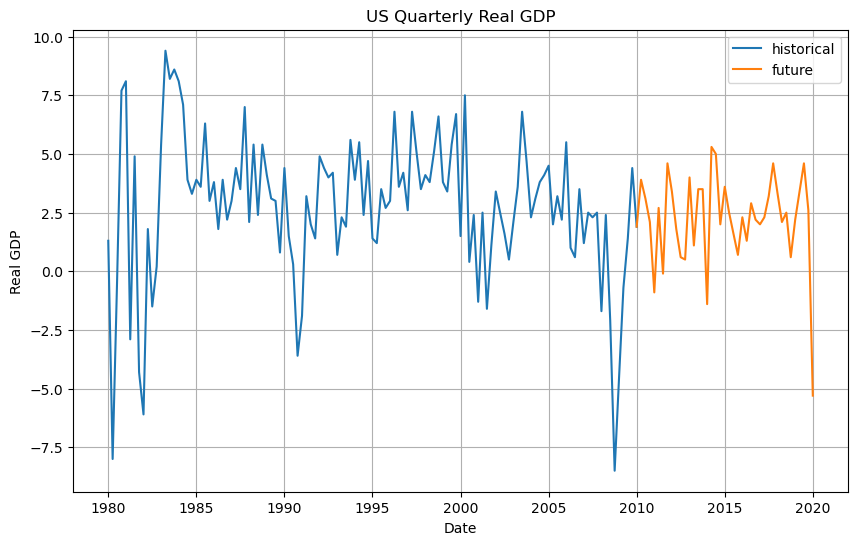

In [6]:
y_hist = gdp['1980-01-01':'2010-01-01']
y_future = gdp['2010-01-01':'2020-01-01']

# Plotting the line chart
plt.figure(figsize=(10, 6))
# plt.plot(y_train.index, y_train['RealGDP'])
plt.plot(y_hist, label = 'historical')
plt.plot(y_future, label = 'future')
plt.legend()
plt.title('US Quarterly Real GDP')
plt.xlabel('Date')
plt.ylabel('Real GDP')
plt.grid(True)
plt.show()

In [12]:
result = adfuller(y_hist)
print(result)

(-5.585301193817848, 1.3672804301577505e-06, 1, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, 475.34350506933606)


Given the p-value of 1.3672804301577505e-06 we can assume the data is stationary.

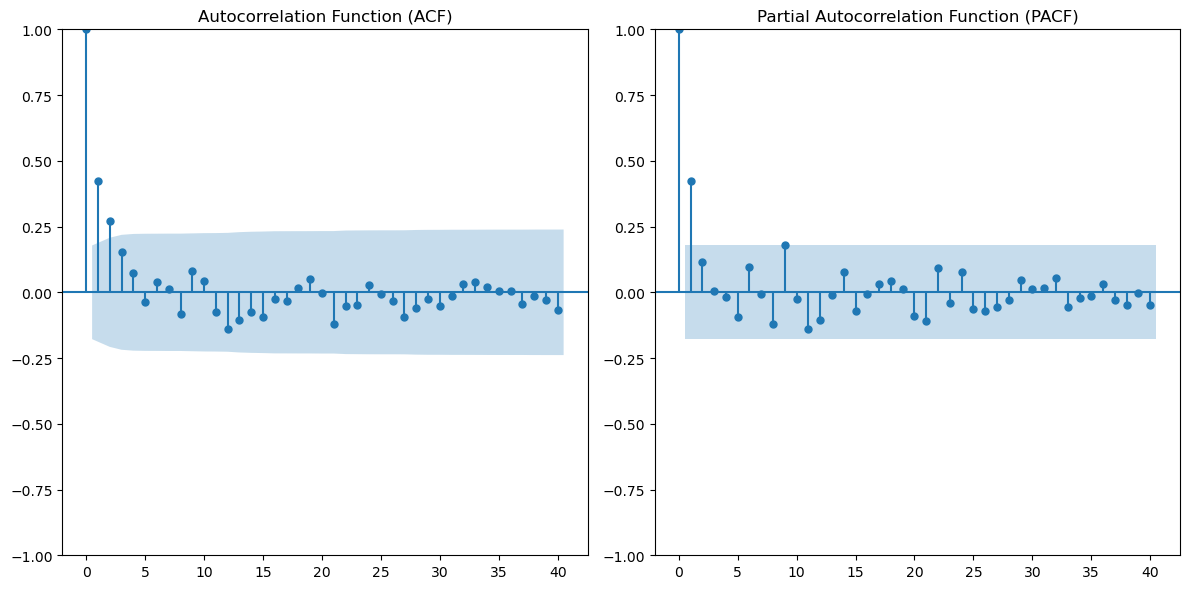

In [19]:
# Plot the ACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(y_hist, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plot the PACF
plt.subplot(122)
plot_pacf(y_hist, lags=40, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

1. Determining p (AR Term) from PACF:
The PACF plot shows a significant spike at lag 1 and then drops off sharply, with subsequent lags being within the confidence interval (close to zero).
This suggests that an AR(1) model is appropriate. We will start with q = 1.
2. Determining q (MA Term) from ACF:
The ACF plot has a significant spike at lags 1 and 2 with the rest being outside of the 5% statistical significance.
This pattern suggests that an MA(2) model might be appropriate. We will start with q = 2.

In [85]:
import itertools

# Define the p, d, q parameters to take any value between 0 and some upper limit
p = d = q = range(0, 4)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate ARIMA models with different pdq values
results = []
for params in pdq:
    try:
        model = ARIMA(y_hist, order=params)
        arma_model = model.fit()
        results.append((params, arma_model.aic, arma_model.bic))
    except:
        continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC', 'BIC'])

# Sort by AIC and BIC
sorted_results = results_df.sort_values(by='AIC', ascending=True)

print(sorted_results.head())  # Show top models

    (p, d, q)         AIC         BIC
55  (3, 1, 3)  594.473587  613.986029
35  (2, 0, 3)  596.533359  616.103893
37  (2, 1, 1)  599.163485  610.313452
22  (1, 1, 2)  599.345056  610.495023
21  (1, 1, 1)  599.379791  607.742266


In [144]:
p = 2
d = 0
q = 3


# Fit the ARMA model
model = ARIMA(y_hist, order=(p, d, q))
arma_model = model.fit()

# Summary of the model
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                RealGDP   No. Observations:                  121
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -291.267
Date:                Wed, 28 Aug 2024   AIC                            596.533
Time:                        11:02:31   BIC                            616.104
Sample:                    01-01-1980   HQIC                           604.482
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7542      0.498      5.527      0.000       1.778       3.731
ar.L1          1.3068      0.074     17.729      0.000       1.162       1.451
ar.L2         -0.8200      0.078    -10.543      0.0

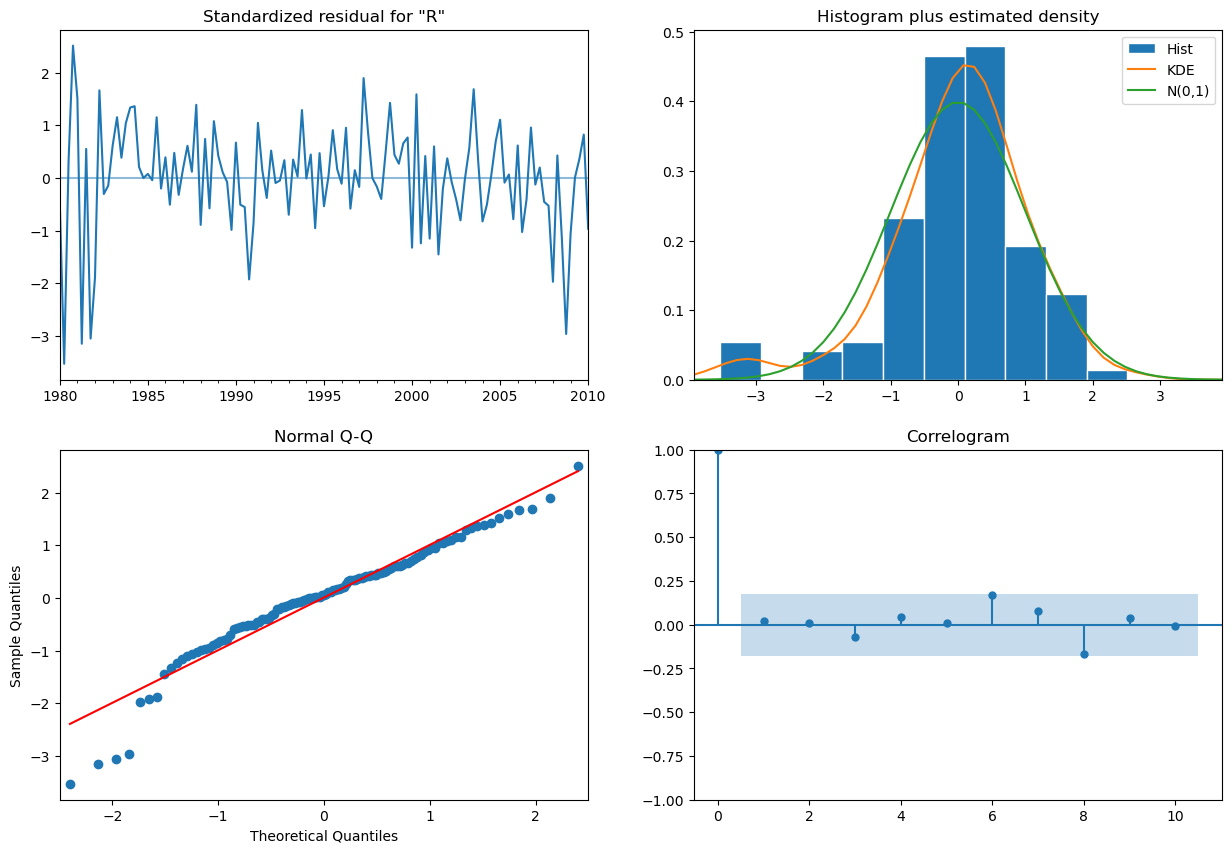

In [146]:
arma_model.plot_diagnostics(figsize=(15, 10))
plt.show()

Standardized Residuals: The residuals appear to be reasonably well-behaved, with no obvious patterns.
Histogram & Q-Q Plot: The residuals are approximately normally distributed, though with some deviation in the tails.
Correlogram: The residuals mostly exhibit no significant autocorrelation, suggesting the model has captured the serial dependence well.

7.467033132085372 2.732587259738538


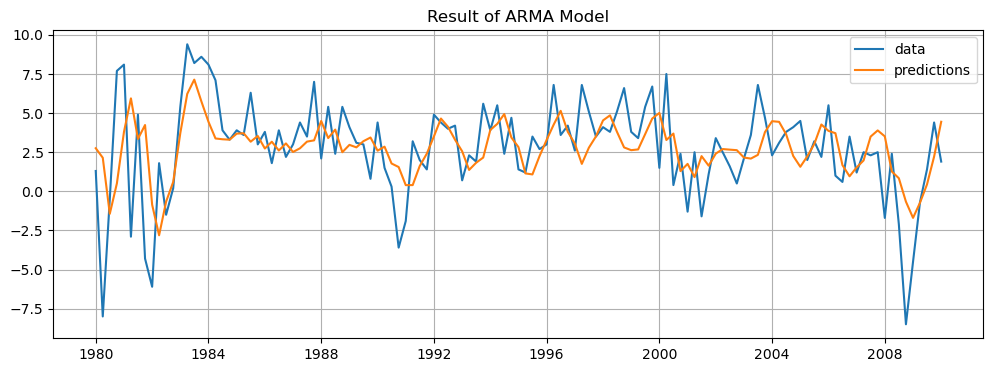

In [149]:
predictions = arma_model.predict()
mse_predictions = mean_squared_error(y_hist, predictions)
rmse_predictions = np.sqrt(mse_predictions)

print(mse_predictions, rmse_predictions)

# Answer check
plt.figure(figsize = (12, 4))
plt.plot(y_hist, label = 'data')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');

In [151]:
# Forecasting
forecast_steps = len(y_future)

forecast = arma_model.forecast(steps = forecast_steps)

mse_forecast = mean_squared_error(y_future, forecast)
rmse_forecast = np.sqrt(mse_forecast)
print(mse_forecast, rmse_forecast)

print(forecast[:5])

3.9317426050915336 1.9828622254436978
2010-04-01    4.644375
2010-07-01    4.642426
2010-10-01    3.098353
2011-01-01    1.655648
2011-04-01    1.036392
Freq: QS-OCT, Name: predicted_mean, dtype: float64


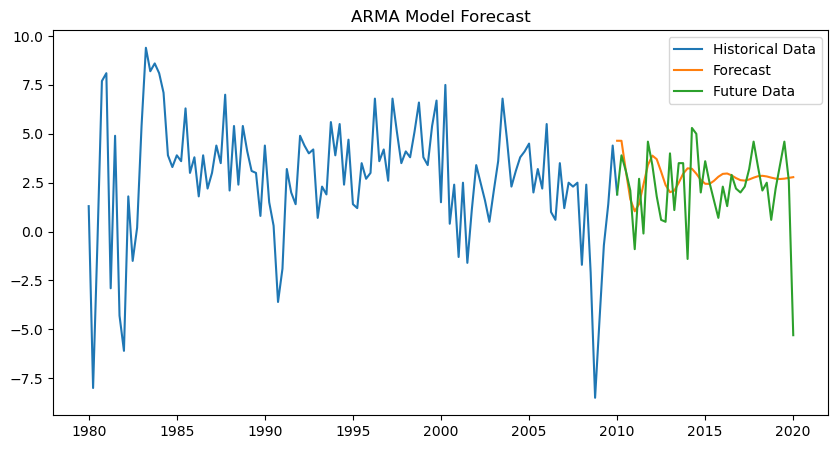

In [153]:
# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(y_hist.index, y_hist, label='Historical Data')
plt.plot(y_future.index, forecast, label='Forecast')
plt.plot(y_future.index, y_future, label='Future Data')
plt.title('ARMA Model Forecast')
plt.legend()
plt.show()